Author: Group E <br>
Date: 2021-03-08 <br>
Licence: MIT License <br>

# Group E Assignment - Bike Sharing Prediction
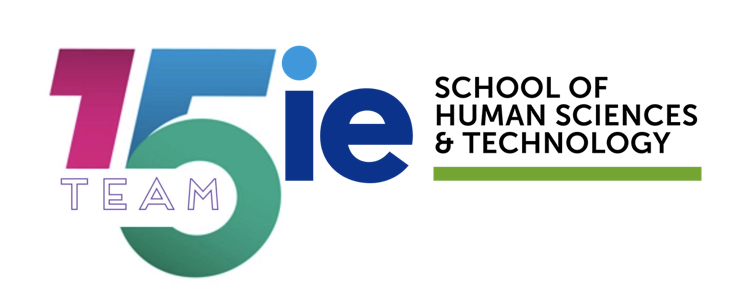

### Table of Contents:
1. Introduction
2. Exploratory Data Analysis
3. Feature Engineering
4. Model Training
5. Conclusion

# 1. Introduction
For this project, we are going to predict the day-ahead price of power in Spain given some forecast available before the daily auction. This will be done by evaluating the different variables which influence that price, such as: demand, supply, dates and forecasts for all energy types. With the analysis of these different variables we will be able to create an accurate prediction model which will help households change their consumer habits in order to reduce their monthly power expenses. In this notebook you will be able to see a variety of different models and feature engineering that we tried and worked with before developing our final prediction model.

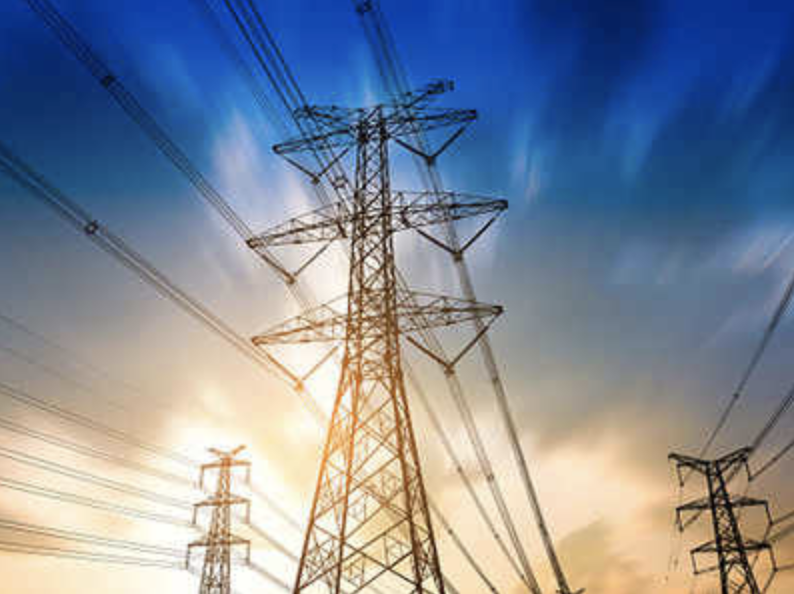

In [1]:
# importing IPython relevant libraries
import warnings
warnings.filterwarnings('ignore')

# import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# data wrangling and other modules
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error

# machine learning modules
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image
from IPython.core.display import HTML 

The provided datasets contain the following timeseries with hourly granularity:
* **date**: date of the observation ”%Y-%m-%d”
* **hour**: hour of the observation, [0 - 23]
* **fc demand**: forecast of demand in MWh
* **fc nuclear**: forecast of nuclear power production in MWh
* **import FR**: forecast of the importing capacity from France to Spain in MWh
* **export FR**: forecast of the exporting capacity from Spain to France in MWh
* **fc wind**: forecast of wind power production in MWh
* **fc solar pv**: forecast of PV solar (solar panels) power production in MWh
* **fc solar th**: forecast of thermal solar power production in MWh
* **price**: power price for each hour in €/MWh. This is the target we want you to
predict.

In [2]:
# Set the seed as a constant to be able to reproduce the experiments properly.
seed = 120

# 2. Exploratory Data Analysis

In [3]:
# importing the data set
df = pd.read_csv('power_market.csv', parse_dates=["date"])

# first glimpse on the data set
df.head(10)

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4
5,19211.0,7117.2,3000.0,2650.0,1662.0,0.0,30.4,44.50,2017-01-01,5
6,19314.0,7117.2,3000.0,2650.0,1684.0,0.0,40.0,44.50,2017-01-01,6
7,19538.0,7117.2,3000.0,2650.0,1780.0,0.0,45.5,44.72,2017-01-01,7
8,19651.0,7117.2,3000.0,2650.0,1803.0,56.5,43.2,44.22,2017-01-01,8
9,20066.0,7117.2,3000.0,2650.0,1737.0,488.3,74.6,45.13,2017-01-01,9


In [4]:
df["price"].mean()

48.44011918468959

The mean power price per hour is approximately 48.44€

In [5]:
# to be used afterwards
date_array = df['date']

In [6]:
# listing all columns
print(df.columns)

# listing length of columns
print("Total number of columns: {}".format(len(df.columns)))

Index(['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind',
       'fc_solar_pv', 'fc_solar_th', 'price', 'date', 'hour'],
      dtype='object')
Total number of columns: 10


There are 9 columns in total, we may have add new columns to find more insights from our data set.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fc_demand    32135 non-null  float64       
 1   fc_nuclear   32135 non-null  float64       
 2   import_FR    32122 non-null  float64       
 3   export_FR    32122 non-null  float64       
 4   fc_wind      32135 non-null  float64       
 5   fc_solar_pv  32135 non-null  float64       
 6   fc_solar_th  32135 non-null  float64       
 7   price        32135 non-null  float64       
 8   date         32135 non-null  datetime64[ns]
 9   hour         32135 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.5 MB


All columns have been correctly formatted. <br>
There are 32135 rows in total.

In [8]:
# get columns with null values and their null count
for column in df:
    if df[column].isnull().any():
       print('{0} has {1} null values'.format(column, df[column].isnull().sum()))

import_FR has 13 null values
export_FR has 13 null values


count    32135.000000
mean        48.440119
std         14.842233
min          0.030000
25%         39.770000
50%         49.880000
75%         58.250000
max        101.990000
Name: price, dtype: float64


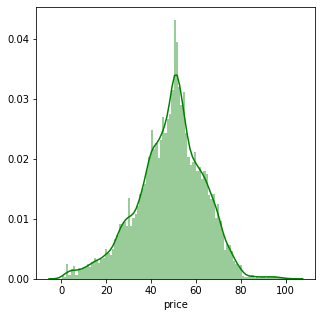

In [9]:
# print summary info regarding the price column
print(df['price'].describe())

# plot the price distribution
plt.figure(figsize=(5, 5))
sns.distplot(df['price'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [10]:
# check for normality using shapiro test
stat, p = shapiro(df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# set the threshold as 0.05 for normality
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)


The price distribution does not follow a Normal Distribution

### 2.1 Correlation Analysis
To better work with this data set it is important to conduct a correlation analysis.

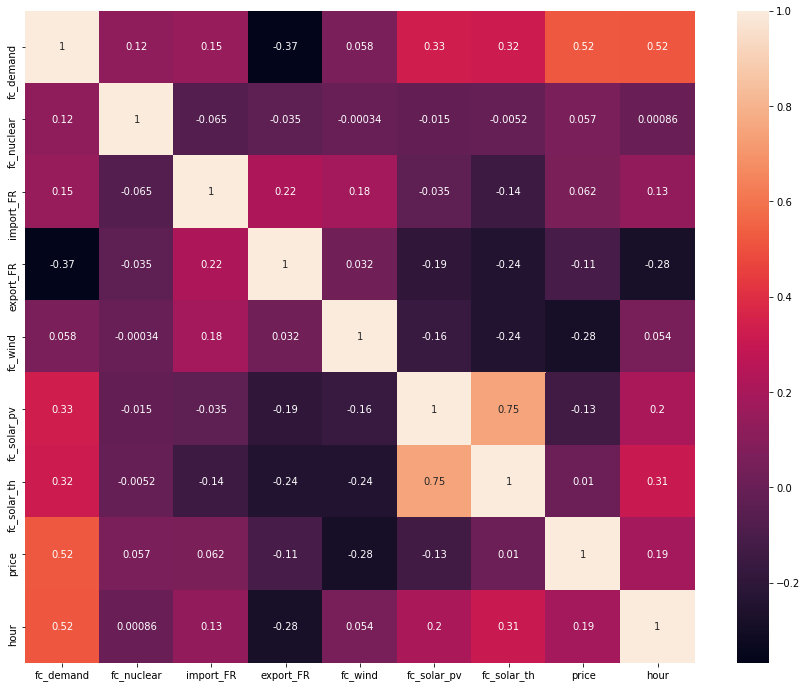

In [11]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True);

* **fc demand**: forecast of demand in MWh has a correlation of **0.52** with **price** and **hour**<br>
* **fc demand**: forecast of demand in MWh has a correlation of **0.12** with **fc_nuclear**<br>
* **fc demand**: forecast of demand in MWh has a correlation of **0.32** with **fc_solar_pv** and **fc_solar_th**<br>
* **fc demand**: forecast of demand in MWh has a correlation of **0.12** with **import_FR**<br>
* **fc demand**: forecast of demand in MWh has a negative correlation of **-0.37** with **export_FR**<br>
<br>
* **price**: price of the power production in €/MWh has a negative correlation of **-0.28** with **fc_wind**<br>
* **price**: price of the power production in €/MWh has a negative correlation of **-0.13** with **fc_solar_pv**<br>
* **price**: price of the power production in €/MWh has a correlation of **0.19** with **hour**<br>
* **price**: price of the power production in €/MWh has a correlation of **-0.11** with **export_FR**<br>
<br>
<br>

**This first resume of the heatmap is recaping the most important correlations with the demand and price:**<br>
- We can appreciate that the demand is highly correlated with price and hour.<br> 
- It is negatively correlated with export, which makes sense because the exporting occurs when the is more production than demand. <br>
- The two types of power which are more correlated to the demand are both solar thermal and photovoltaic.<br>
- The price is negatively correlated with wind and solar photovoltaic power, which means that when its production increase it lower the price, which makes sense as they are natural energy. <br>
- The price is also negatively correlated with export for the same reason as the demand. When this occurs there is an excess and lowers the price.<br>
- The price is highly correlated to hour and demand. 


# 3. Feature Engineering

In [12]:
df.tail()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
32130,28832.0,7117.2,2200.0,1750.0,2846.0,2035.0,1615.4,47.88,2020-08-31,19
32131,29453.0,7117.2,2200.0,1750.0,2861.0,325.8,1017.3,51.18,2020-08-31,20
32132,30685.0,7117.2,2200.0,1750.0,2859.0,0.0,682.5,55.69,2020-08-31,21
32133,28699.0,7117.2,2200.0,1750.0,2771.0,0.0,598.3,50.77,2020-08-31,22
32134,26672.0,7117.2,2200.0,1750.0,2746.0,0.0,617.8,45.00,2020-08-31,23


The last date is 2020-08-31. We can see we have 3 years and 8 months of data.

In [13]:
def create_thermal_gap(df):
    df['thermal_gap'] = df['fc_demand'] - (df['fc_nuclear'] + df['fc_solar_pv'] + df['fc_solar_th'] + df['fc_wind'])
    return df

The price is highly influenced by the demand (which we have info) and by the "expensive productions" which we don't have explicit data from. <br>
What we know is that these "expensive productions" are produced after the "cheap productions" (which are nuclear, wind and solar) run out. So in order to calculate it we have substracted the sum of the "cheap productions" to the demand, which benefited the prediction score of the model.<br>

In [14]:
def create_net_exc_power(df):
    # impute and create a difference column with the median
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    df["export_FR"]  = imp.fit_transform(df[["export_FR"]])
    df["import_FR"]  = imp.fit_transform(df[["import_FR"]])
    df["export_FR"] = df["export_FR"].astype(int)
    df["import_FR"] = df["import_FR"].astype(int)
    df['net_exc_power'] = df['export_FR'] - df['import_FR']
    df['net_exc_power'] = df['net_exc_power'].astype(int) # convert the column to int
    df = df.drop(columns=["import_FR", "export_FR"]) # drop import_FR and export_FR columns after manipulation
    return df

In [15]:
def remove_irrelevant_columns(df):
    df = df.drop(columns=["fc_demand", "date", "fc_solar_pv"]) # drop fc_demand and date
    return df

### 3.1 Column processing

As there where missing values in export and import columns we have imputed these missing values with the median. <br>
We have created a new variable called net_exc_power to calculate the overall result of the exportation and importation and use this variable to see the influence in the price. 

In [16]:
# pipelining function to be used for each input data
def apply_feature_engineering(df):
    df = create_thermal_gap(df)
    df = create_net_exc_power(df)
    df = remove_irrelevant_columns(df)
    return df

In [17]:
# apply all feature engineering functions
df = apply_feature_engineering(df)

### 3.2 Correlation analysis on cleaned data

<AxesSubplot:>

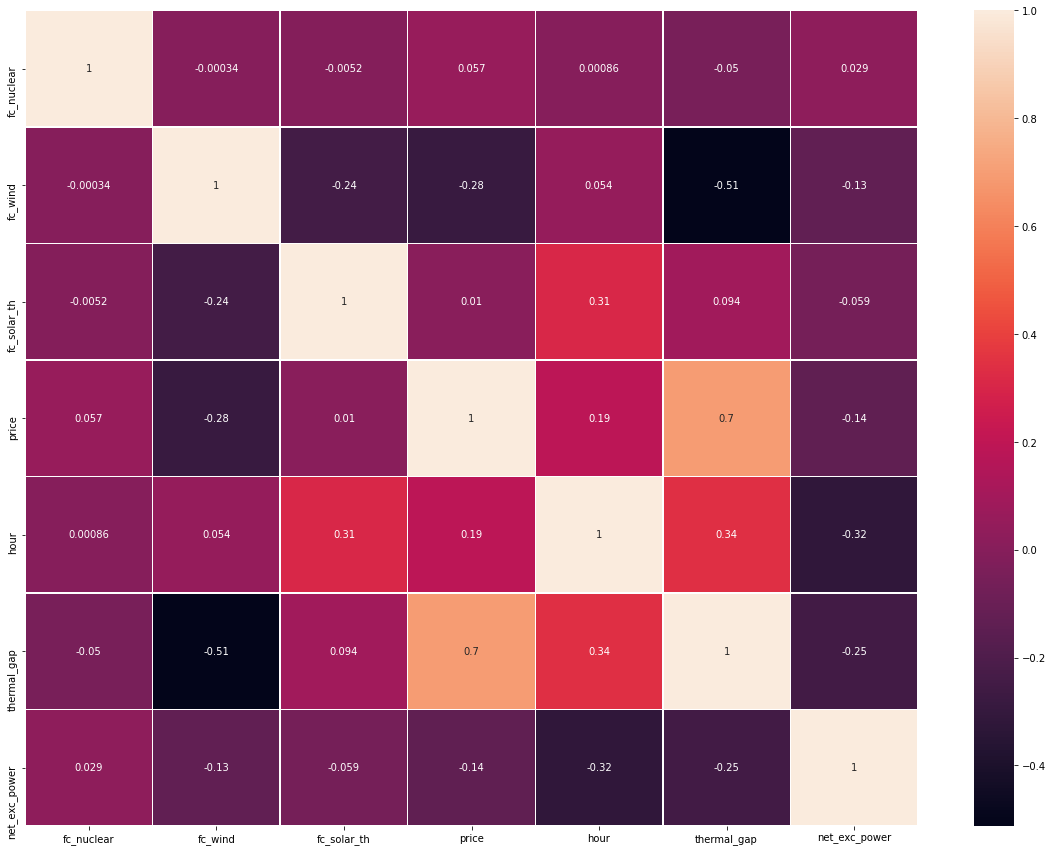

In [18]:
# correlation heatmap after feature engineering
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

* **price**: price of the power production in €/MWh has a correlation of **0.7** with **thermal_gap**<br>
* **price**: price of the power production in €/MWh has a negative correlation of **-0.14** with **net_exc_power**<br>
<br>

* **thermal_gap**: forecast of the 'expensive power' production in MWh has a negative correlation of **-0.25** with **net_exc_power**<br>
* **thermal_gap**: forecast of the 'expensive power' production in MWh has a negative correlation of **-0.51** with **fc_wind**<br>
<br>
The high correlation of the price with the thermal gap is due to the description of the thermal gap: the expensive powers. The price is negatively correlated with the net exchanged power because there is more importation than exportation. <br>
The thermal gap is negatively correlated with the net exchange power because the exchange is with "cheap energy". Finally the thermal gap is negatively correlated with the wind power forecast because as more wind power there is, the less "expensive powers" are used. 
<br>
The rest of correlations are the same as before.
<br>
With the creation of new variables we need to select the ones we are going to use in our algorithm in order to avoid overfitting and noise.<br>
<br>

### 3.3 Data engineering results
Variables to be used and to be removed have been identified for the benefit of this report. They have been identified as follows.

**Variables to use:**
1. Thermal_gap
2. Net_exc_power.
3. Demand
4. Solar, nuclear and wind productions
5. Price: target <br>
<br>

**Variables to remove:**
1. Import and export, as we have net_exc_power calculated by the difference of both.

# 4. Model Training
At first the data will be divided in regards to the variable that is aimed to be predicted "price".

In [19]:
train_test_split_ratio = 0.17

In [20]:
# separate feature and target columns
X = df.drop(columns=["price"])
y = df['price']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=train_test_split_ratio, random_state=seed)

### 4.1 Pipeline creation and model training

In [22]:
clf = Pipeline([
   ("regression", LinearRegression())
])

In [23]:
# we ran all of these algorithms but after scoring them we kept only a portion of them for faster testing
param_grid = [
    {
        "regression": [LinearRegression()],
        "regression__normalize": [False], # True tried
    },
    #{
    #    "regression": [DecisionTreeRegressor()], 
    #    "regression__max_depth": [15], # 5, 10, 20 tried
    #    "regression__random_state": [seed],
    #},
    #{
    #     "regression": [RandomForestRegressor()],
    #     "regression__random_state": [seed],
    #     "regression__max_depth": [10, 15], # 5, 20 tried
    #     "regression__n_estimators": [300, 400],  # total number of trees that will be created # 30, 50, 100, 200 tried
    #     "regression__max_features": [0.5] # 0.6, 0.7, 0.8 tried
    #},
    {
        "regression": [XGBRegressor()],
        "regression__random_state": [seed],
        "regression__max_depth": [15], # 5, 10, 20 tried
        "regression__n_estimators": [100],  # total number of trees that will be created # 200 tried
        "regression__learning_rate": [0.1],  # how much each tree will learn # 0.01 tried
        "regression__early_stopping_rounds": [15]  # 20 tried
    }
]

In [24]:
# neg_root_mean_squared_error
clf = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, scoring="neg_root_mean_squared_error")

In [25]:
clf.fit(X_train, y_train)

[21:49:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regression', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'regression': [LinearRegression()],
                          'regression__normalize': [False]},
                         {'regression': [XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=15,
                                                      gamma=None, gpu_id=None,
                                                      importan...
                                                      random_state=120,
                                                      reg_alpha=None,
                   

In [26]:
# we thought xgboost or random forest regressor would score better, but the winner was the simple linear regression model.
clf.best_params_

{'regression': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=15, gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=15,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=120, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 'regression__early_stopping_rounds': 15,
 'regression__learning_rate': 0.1,
 'regression__max_depth': 15,
 'regression__n_estimators': 100,
 'regression__random_state': 120}

In [27]:
# the root_mean_squared_error is given negatively
clf.best_score_ * -1

6.112074929300597

In [28]:
# check the best estimator
clf.best_estimator_

Pipeline(steps=[('regression',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=15,
                              gamma=0, gpu_id=-1, importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=15,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=4, num_parallel_tree=1, random_state=120,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [29]:
# showing all trials for comparison
clf.cv_results_

{'mean_fit_time': array([2.51220226e-02, 2.70521272e+01]),
 'std_fit_time': array([6.56500001e-03, 7.61255665e+00]),
 'mean_score_time': array([0.00621681, 0.09087205]),
 'std_score_time': array([0.00092261, 0.02698886]),
 'param_regression': masked_array(data=[LinearRegression(),
                    XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=15, gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=15,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=120, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)],
              mask=[False, Fa

### 4.2 Model scoring
Here it is particulrly important to see how the best model is performing in a testing context.

In [30]:
# list all the scores
test_scores = clf.cv_results_['mean_test_score'] * (-1)
test_scores

array([10.42096209,  6.11207493])

In [31]:
# store the best model in a variable
best_model = clf.best_estimator_
best_model

Pipeline(steps=[('regression',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=15,
                              gamma=0, gpu_id=-1, importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=15,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=4, num_parallel_tree=1, random_state=120,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [32]:
# import the scoring data set
# scoring = pd.read_csv("scoring.csv", parse_dates=["date"])

In [33]:
# prepare the scoring data set for the model
# scoring = apply_feature_engineering(scoring)

Compare lengths of data sets:

In [34]:
# len(scoring.columns)

In [35]:
len(X.columns)

6

In [36]:
# make predictions out of the scoring data set
# predictions = best_model.predict(scoring)

In [37]:
# make predictions out of the scoring data set
predictions = best_model.predict(X_test)

Compare means of data sets:

In [38]:
df["price"].mean() 

48.44011918468959

In [39]:
predictions.mean()

48.45218

Calculate the root mean squared error:

In [40]:
np.sqrt(mean_squared_error(y_test, predictions))

5.837153152049135

### 4.3 Time series: prediction vs actual price

In [41]:
comparison_df = pd.DataFrame()
comparison_df['price'] = y_test
comparison_df['predictions'] = predictions
comparison_df.head(20)

,price,predictions
10610,39.91,35.113655
21214,55.26,50.893616
7721,68.26,61.428688
25186,50.90,50.405659
14926,70.29,54.397339
24856,30.00,23.545118
3865,44.00,45.593777
13873,54.90,46.369789
25094,44.26,44.162258
22362,49.50,44.056099


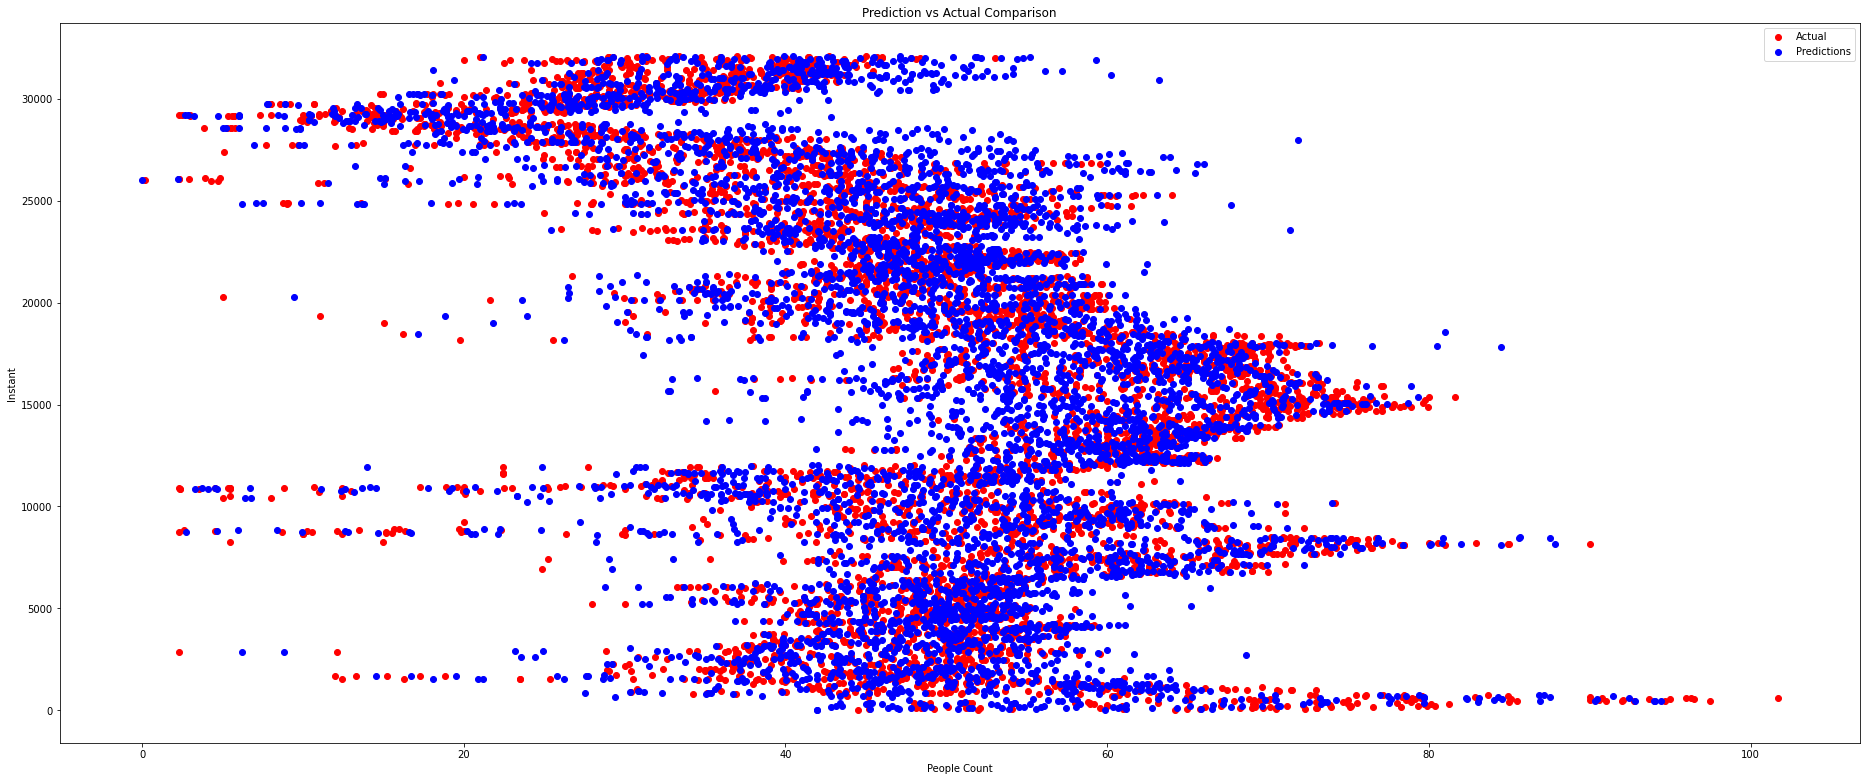

In [42]:
actual_scatter = comparison_df["price"]
prediction_scatter = comparison_df["predictions"]
instance_range = comparison_df.index
fig=plt.figure()

# change the size of plots
fig.set_size_inches(25, 10, forward=True)
ax=fig.add_axes([0,0,1,1])
ax.scatter(actual_scatter, instance_range, color='r', label="Actual")
ax.scatter(prediction_scatter, instance_range, color='b', label="Predictions")
ax.set_xlabel('People Count')
ax.set_ylabel('Instant')
ax.set_title('Prediction vs Actual Comparison')

plt.legend()
plt.show()

In [43]:
# determines cross-validated training and test scores for different training set sizes.
# .values will give the values in an array. (shape: (n,1) and .ravel will convert that array shape to (n, )
#train_sizes, train_scores, cv_scores = learning_curve(clf.best_estimator_, X_train, y_train.values.ravel(), cv=5)

#plt.plot(train_sizes, train_scores.mean(axis=1), label="Train scores")
#plt.plot(train_sizes, cv_scores.mean(axis=1), label="CV scores")

#plt.legend()

In [44]:
# round to two numbers
# scoring['price'] = np.round(predictions, 2)

In [45]:
# create a csv file with predictions
# scoring.to_csv('scoring_price.csv')

# 6. Conclusion

This report focuses on finding a good prediction for the next day electricity price. For this several steps were conducted. In the exploratory data analysis it was discovered that the mean power price per hour is around 48€ and that the distribution is not normally distributed. In the correlation analysis it was identified, that demand is highly correlated with price and hour, negatively correlated with export as well as the price being negatively correlated with renewable energies. These findings laid the foundation for the feature engineering, where that lead to creating a thermal gap function where demand was adjusted for the two energy types and the irrelevant columns have been dropped. 
Hence, thermal_gap, net_exc_power, demand, production types and the price target were used in the model training. After preprocessing it was found out that surprisingly LogisticRegression was the best algorithm for the purpose of this study. Then gridsearch cross validation was run to identify the best mean square error (MSE). A MSE of approximately 11.8 highlights the significance of this model. Finally when comparing the scoring.csv mean of approximately 48€ with the prediction's mean of approximately 48€, it further emphasises the validity of this model. Finally in the time series it can be obtained how close this model's price predictions are to the actual prices.
To conclude, the simplicity of this model is the beauty. With the help of a simple LinearRegression algorithm, this model can definitely predict the electricity prices of the following day for expectation management in the future. 